# Mat Simpson 

## Queensland University of Technology, Australia

## SIAM Life Sciences 2024

## matthew.simpson @ qut.edu.au   

In [1]:
using Plots, DifferentialEquations,Interpolations, 
Random, Distributions, NLopt, Dierckx,LaTeXStrings
gr();

In [16]:
a=zeros(2); Tend=100; T0=180.0; t=LinRange(0,Tend,11); σ=8.0; tt=LinRange(0,Tend,101);

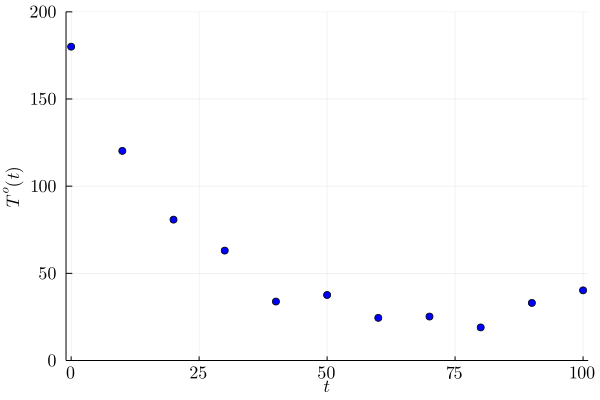

In [17]:
data=[180,120.23289494816545,80.80223383339003,63.043377610898446,33.82110519931399,37.58253928898577,
    24.466743123119954,25.20867035519172,18.974232471938194,33.03717277223526,40.23754940875503];
p1=scatter(t,data,mc=:blue,msc=:match,label=false)
p1=plot!(xlabel=L"t",ylabel=L"T^o(t)",color=:red,xlims=(t[1]-1,t[end]+1), ylims=(0,200),xticks = ([0,25,50, 75, 100],[L"0", L"25", L"50", L"75", L"100"]), yticks = ([0,50,100,150,200],[L"0", L"50", L"100", L"150",L"200"]),label=false)
p1=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
display(p1);

Process model

\begin{align}
\large{\dfrac{\textrm{d}T(t)}{\textrm{d}t}}&=\large{- k \left(T(t) - T_a\right),} \notag \\  
\large{T(t)} &\large{= \left(T(0) - T_{a} \right)\textrm{e}^{-kt} + T_{a}.}
\end{align}

For simplicity, let's assume that $T(0)$ is known (e.g. measurable)

\begin{equation}
\large{\theta = (T_{a},k)^\mathsf{T}}
\end{equation}

In [18]:
function model(t,T0,a)
y=zeros(length(t))
T(t) = a[1]+(T0-a[1])*exp(-a[2]*t)
    for i in 1:length(t) 
    y[i] = T(t[i])
    end 
return y
end;

Noise (measurement) model: Additive Gaussian

\begin{equation}
\large{T^{o}(t) \mid \theta = \mathcal{N}\left(T(t), \sigma^2\right)}
\end{equation}

Series of $I$ measurements leads to log-likelihood function

\begin{equation}
\large{\ell(\theta \mid T^{o}(t)) = \sum_{i=1}^{I} \log \left [\phi\left(T^{o}(t_i); T(t_i), \sigma^2 \right)\right],}
\end{equation}

where $\phi(x; \mu, \sigma^2)$ denotes the probability density function of the normal distribution with mean $\mu$, variance $\sigma^2$.


In [19]:
function loglhood(data,T0,a,σ)
    y=zeros(length(t))
    y=model(t,T0,a);
    e=0;
    dist=Normal(0,σ);
    e=loglikelihood(dist,data-y) 
    return sum(e)
end;

Maximise the log-likelihood function 

\begin{equation}
\large{\sup_{\theta} \ell(\theta \mid T^{o}(t)) \Rightarrow \hat{\theta}}
\end{equation}

Allows us to work with normalised log-likelihood 

\begin{equation}
	\large{\bar{\ell}(\theta \mid T^{o}(t)) = \ell(\theta \mid T^{o}(t)) - \ell(\hat{\theta} \mid T^{o}(t))}
\end{equation}

In [20]:
function Optimise(fun,θ₀,lb,ub)    
    tomax=(θ,∂θ)->fun(θ)
    opt=Opt(:LN_NELDERMEAD,length(θ₀))
    opt.max_objective=tomax
    opt.lower_bounds=lb      
    opt.upper_bounds=ub
    opt.maxtime=1*60
    res = optimize(opt,θ₀)
    return res[[2,1]]
end

Optimise (generic function with 1 method)

In [21]:
a=zeros(2)
function funmle(a)
return loglhood(data,T0,a,σ)
end

funmle (generic function with 1 method)

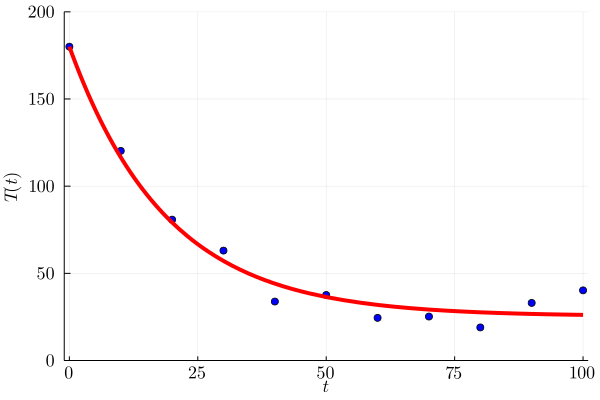

In [22]:
Tamin=0;Tamax=100;kmin=0;kmax=1;
θG=[20, 0.05]
lb=[Tamin,kmin]
ub=[Tamax,kmax]
(xopt,fopt)=Optimise(funmle,θG,lb,ub)
Tamle=xopt[1]
kmle=xopt[2]
fmle=fopt
Tmle(t) = xopt[1]+(T0-xopt[1])*exp(-xopt[2]*t)
p1=plot!(Tmle,t[1],t[end],lw=4,xlabel=L"t",ylabel=L"T(t)",color=:red,xlims=(t[1]-1,t[end]+1), ylims=(0,200),xticks = ([0,25,50, 75, 100],[L"0", L"25", L"50", L"75", L"100"]), yticks = ([0,50,100,150,200],[L"0", L"50", L"100", L"150",L"200"]),label=false)
p1=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)

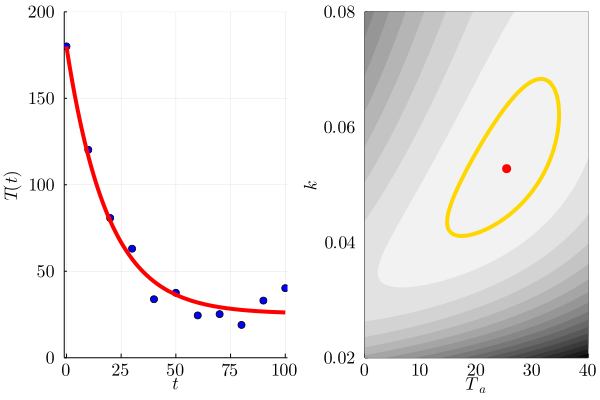

In [23]:
Q=100
Taa=LinRange(0,40,Q);
kk=LinRange(0.02,0.08,Q);
df=2
llstar=-quantile(Chisq(df),0.95)/2
p2=contourf(Taa,kk,(Taa,kk)->funmle([Taa,kk])-fopt,lw=0,xlabel=L"T_a",ylabel=L"k",c=:grays,colorbar=:false)
p2=scatter!([Tamle],[kmle],markersize=3,markershape=:circle,markercolor=:red,msw=0,ms=5,label=false)
p2=contour!(Taa,kk,(Taa,kk)->funmle([Taa,kk])-fopt,levels=[llstar],lw=4,c=:gold,legend=false)
p2=plot!(xlims=(0,40),xticks=([0,10,20,30,40],[L"0",L"10", L"20", L"30", L"40"]))
p2=plot!(ylims=(0.02,0.08),yticks=([0.02,0.04,0.06,0.08],[L"0.02", L"0.04", L"0.06", L"0.08"]))
p2=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
p3=plot(p1,p2,layout=(1,2))

\begin{equation}
\large{\bar{\ell} \ge \bar{\ell}^{*} = -\dfrac{\Delta_{n,q}}{2}}
\end{equation}   

Where $\Delta_{n,q}$ $q$th quantile of a $\chi^2$ distribution with $n$ degrees of freedom. Here the 95$\%$ confidence 
interval $\bar{\ell}^{*} = -\Delta_{2,0.95}/2  \approx -2.9957$.


In [24]:
df=1
llstar=-quantile(Chisq(df),0.95)/2

function univariateTa(Ta)
    a=zeros(1)    
    function funTa(a)
    return loglhood(data,T0,[Ta,a[1]],σ)
    end
    θG=[kmle]
    lb=[kmin] 
    ub=[kmax] 
    (xopt,fopt)=Optimise(funTa,θG,lb,ub)
    return fopt,xopt
    end 
    f(x) = univariateTa(x)[1]

#Take a grid of M points to plot the univariate profile likelihood
M=50;
Tarange=LinRange(0,40,M)
ff=zeros(M)
for i in 1:M
    ff[i]=univariateTa(Tarange[i])[1]
end

q2=hline([llstar],legend=false,lw=4,color=:gold);
q2=vline!([Tamle],legend=false,xlabel=L"T_a",ylabel=L"\bar{\ell}_p",lw=4,color=:blue);
sp2=Spline1D(Tarange,ff.-maximum(ff),w=ones(length(Tarange)),k=3,bc="nearest",s=1/500);
yy=evaluate(sp2,Tarange);
q2=plot!(Tarange,yy,lw=4,lc=:red,ylims=(-3,0.1),xlims=(Tarange[1],Tarange[end]));
q2=plot!(xticks=([10,20,30,40],[L"10", L"20", L"30", L"40"]));
q2=plot!(yticks=([0,-1,-2,-3],[L"0", L"-1", L"-2", L"-3"]));
q2=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12);

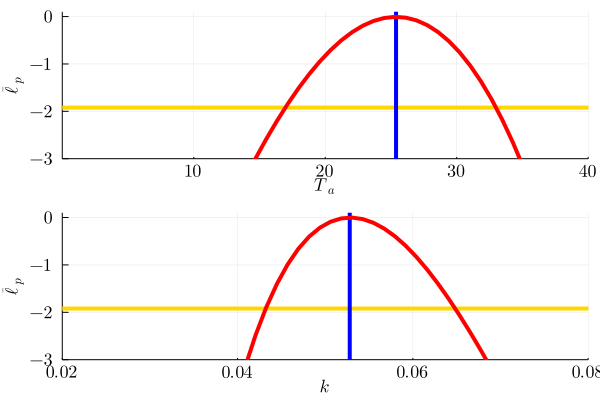

In [27]:
function univariatek(k)
    a=zeros(2)    
    function funk(a)
    return loglhood(data,T0,[a[1],k],σ)
    end
    θG=[Tamle]
    lb=[Tamin] 
    ub=[Tamax] 
    (xopt,fopt)=Optimise(funk,θG,lb,ub)
    return fopt,xopt
    end 
    f(x) = univariatek(x)[1]

#Take a grid of M points to plot the univariate profile likelihood
M=50;
krange=LinRange(0.02,0.08,M)
ff=zeros(M)
for i in 1:M
    ff[i]=univariatek(krange[i])[1]
end

q3=hline([llstar],legend=false,lw=4,color=:gold);
q3=vline!([kmle],legend=false,xlabel=L"k",ylabel=L"\bar{\ell}_p",lw=4,color=:blue);
sp3=Spline1D(krange,ff.-maximum(ff),w=ones(length(krange)),k=3,bc="nearest",s=1/100);
yy=evaluate(sp3,krange);
q3=plot!(krange,yy,lw=4,lc=:red,ylims=(-3,0.1),xlims=(krange[1],krange[end]));
q3=plot!(xticks=([0.02,0.04,0.06,0.08],[L"0.02", L"0.04", L"0.06", L"0.08"]));
q3=plot!(yticks=([0,-1,-2,-3],[L"0", L"-1", L"-2", L"-3"]));
q3=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12);
q1=plot(q2,q3,layout=(2,1))

# Prediction: Two approaches

## 1. Grid up the log-likelihood function,

## 2. Rejection sampling of the log-likelihood function to generate M samples, 
    
    
    
\begin{equation}
\large{\bar{\ell}(\theta \mid T^{o}(t)) \ge \bar{\ell}^*}
\end{equation}    
    
    
     

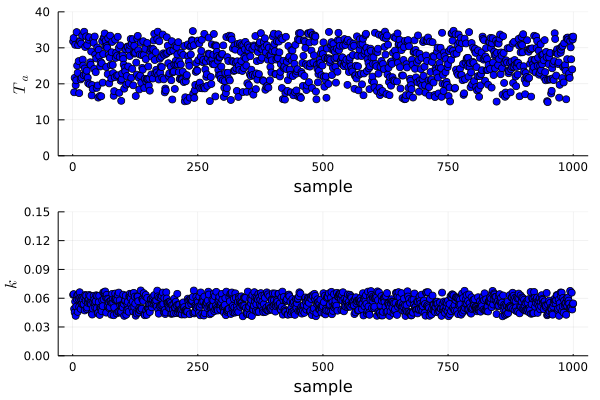

In [28]:
Tamin=0; Tamax=40; kmin=0.0; kmax=0.15;
df=2
llstar=-quantile(Chisq(df),0.95)/2

M=1000
Tasampled=zeros(M)
ksampled=zeros(M)
lls=zeros(M)
global kount = 0
while kount < M
Tag=rand(Uniform(Tamin,Tamax))
kg=rand(Uniform(kmin,kmax))
    if (loglhood(data,T0,[Tag,kg],σ)-fmle) >= llstar
     global kount+=1
    lls[kount]=loglhood(data,T0,[Tag,kg],σ)-fmle
    Tasampled[kount]=Tag;
    ksampled[kount]=kg;
    end
end
a1=scatter(Tasampled,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"T_a",ylims=(Tamin,Tamax));
a2=scatter(ksampled,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"k",ylims=(kmin,kmax));
a3=plot(a1,a2,layout=(2,1))

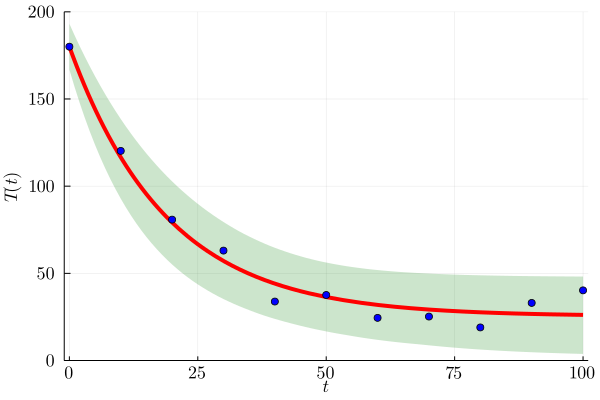

In [32]:
lower=10*Tamle*ones(length(tt))
upper=zeros(length(tt))
for i in 1:M
    Ts(t) = Tasampled[i]+(T0-Tasampled[i])*exp(-ksampled[i]*t)
    
        for j in 1:length(tt)
            if Ts(tt[j])+quantile(Normal(0,σ),[0.05,0.95])[1] < lower[j] 
                lower[j] = Ts(tt[j])+quantile(Normal(0,σ),[0.05,0.95])[1]
            end
           
            if Ts(tt[j])+quantile(Normal(0,σ),[0.05,0.95])[2] > upper[j] 
                upper[j] = Ts(tt[j])+quantile(Normal(0,σ),[0.05,0.95])[2] 
            end
           
        end
    
end
    

    q2=plot(tt,lower,lw=0,fillrange=upper,fillalpha=0.20,color=:green,label=false,xlims=(tt[1]-1,tt[end]+1))
    q2=plot!(Tmle,tt[1],tt[end],lw=4,xlabel=L"t",ylabel=L"T(t)",color=:red,label=false,ylims=(0,200))
    q2=plot!(xticks = ([0,25,50, 75, 100],[L"0", L"25", L"50", L"75", L"100"]))
    q2=plot!(yticks = ([0,50,100,150,200],[L"0", L"50", L"100", L"150",L"200"]))
    q2=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
    q2=scatter!(t,data,mc=:blue,msc=:match,label=false)
display(q2)

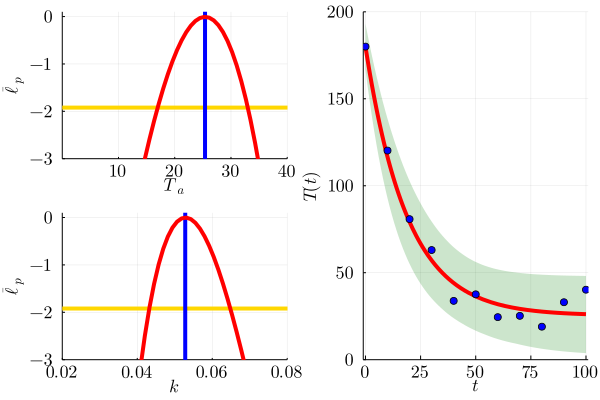

In [33]:
q3=plot(q1,q2,layout=(1,2))